In [503]:
import numpy as np

import mujoco
# from mujoco import mjx
import mediapy as media
import matplotlib.pyplot as plt
from IPython.display import display, Video

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [504]:
# Load model from file
model = mujoco.MjModel.from_xml_path("./models/quadruped/scene.xml")
data = mujoco.MjData(model)

duration = 10  # (seconds)
framerate = 30  # (Hz)
width, height = 720, 480  # Desired resolution

# Apply random inputs to the actuators
mujoco.mj_resetData(model, data)
# data.ctrl[:] = np.random.uniform(-1, 1, data.ctrl.shape)
data.ctrl[:] = np.array([0, 0, -0.5] * 4)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = False
scene_option.geomgroup[:] = 1  # Enable visibility for all groups

count = 0

# Simulate and display video.
frames = []
joint_angles = []
with mujoco.Renderer(model, width=width, height=height) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    joint_angles.append(data.sensordata.copy()) # Record joint angles
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

    if count < data.time * 10:
      data.ctrl[:] = np.random.uniform(-1, 1, data.ctrl.shape)
      count += 1

# Save the video to a file in WebM format using VP8 codec
video_path = "videos/simulation.webm"
media.write_video(video_path, frames, fps=framerate, codec='vp8', bps=1e6)

# Display the video in the notebook
display(Video(video_path, embed=True))

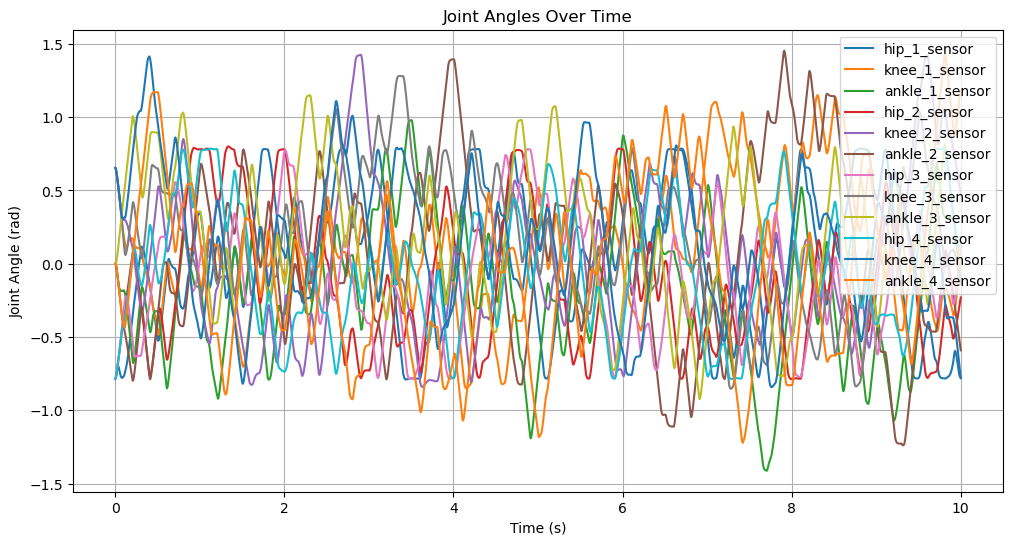

In [505]:
# Plot joint angles with joint names in legend
joint_angles = np.array(joint_angles)
time = np.linspace(0, duration, joint_angles.shape[0])

plt.figure(figsize=(12, 6))
sensor_names = [model.sensor(i).name for i in range(12)]
for i in range(12):
    plt.plot(time, joint_angles[:, i], label=sensor_names[i])
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.title('Joint Angles Over Time')
plt.legend()
plt.grid(True)
plt.show()